# Import Libraries 

In [4]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
from torchvision import transforms
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import tenseal as ts

In [5]:
img_width, img_height = 28,28

In [6]:
class LungCancerDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data_dir = data_dir
    self.image_paths = []
    self.labels = []
    
    for class_dir in ["Bengin Cases", "Normal Cases", "Malignant Cases"]:
      class_path = os.path.join(data_dir, class_dir)
      for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        self.image_paths.append(image_path)
        label = {"Bengin Cases": 0, "Normal Cases": 1, "Malignant Cases": 2}[class_dir]
        self.labels.append(label)
    
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    image = load_image(image_path)  
    label = self.labels[idx]
    if self.transform:
      image = self.transform(image)
    return image, label

def load_image(path):
  image = Image.open(rf"{path}")
  return image



# Define Transform

In [7]:
transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

# Create Data loader

In [8]:

# Create dataset instance
dataset = LungCancerDataset(data_dir=r"Dataset", transform=transform)

# Split dataset into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=9, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Architecture

In [11]:
class ConvNet(torch.nn.Module):
    def __init__(self, hidden=64, output=10):
        super(ConvNet, self).__init__()        
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=7, padding=0, stride=3)
        self.fc1 = torch.nn.Linear(256, hidden)
        self.fc2 = torch.nn.Linear(hidden, output)

    def forward(self, x):
        x = self.conv1(x)
        x = x * x
        # flattening while keeping the batch axis
        x = x.view(-1, 256)
        x = self.fc1(x)
        x = x * x
        x = self.fc2(x)
        return x

# Training Base Model

In [12]:
def train(model, train_loader, criterion, optimizer, n_epochs=10):
    model.train()
    for epoch in range(1, n_epochs+1):

        train_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # calculate average losses
        train_loss = train_loss / len(train_loader)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    # model in evaluation mode
    model.eval()
    return model


model = ConvNet()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = train(model, train_loader, criterion, optimizer, 10)

Epoch: 1 	Training Loss: 0.974996
Epoch: 2 	Training Loss: 0.416832
Epoch: 3 	Training Loss: 0.255511
Epoch: 4 	Training Loss: 0.182620
Epoch: 5 	Training Loss: 0.163781
Epoch: 6 	Training Loss: 0.088723
Epoch: 7 	Training Loss: 0.077446
Epoch: 8 	Training Loss: 0.051544
Epoch: 9 	Training Loss: 0.034966
Epoch: 10 	Training Loss: 0.027642


In [16]:
torch.cuda.current_device()
torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1050'

# Test Accuracy of Base Model

In [17]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        # images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 95.45%


# Encrypted Model based on base Model

In [22]:
class EncConvNet:
    def __init__(self, torch_nn):
        self.conv1_weight = torch_nn.conv1.weight.data.view(
            torch_nn.conv1.out_channels, torch_nn.conv1.kernel_size[0],
            torch_nn.conv1.kernel_size[1]
        ).tolist()
        self.conv1_bias = torch_nn.conv1.bias.data.tolist()
        
        self.fc1_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc1_bias = torch_nn.fc1.bias.data.tolist()
        
        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()
        
        
    def forward(self, enc_x, windows_nb):
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv1_weight, self.conv1_bias):
            y = enc_x.conv2d_im2col(kernel, windows_nb) + bias
            enc_channels.append(y)
        # pack all channels into a single flattened vector
        enc_x = ts.CKKSVector.pack_vectors(enc_channels)
        # square activation
        enc_x.square_()
        # fc1 layer
        enc_x = enc_x.mm(self.fc1_weight) + self.fc1_bias
        # square activation
        enc_x.square_()
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    
def enc_test(context, model, test_loader, criterion, kernel_shape, stride):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    print(len(test_loader))
    count = 0
    for data, target in test_loader:
        count += 1
        print("#",count)
        x_enc, windows_nb = ts.im2col_encoding(
            context, data.view(28, 28).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )
        enc_output = enc_models(x_enc, windows_nb)

        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)

        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()
        
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))

        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1


    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    return class_correct, class_total


kernel_shape = model.conv1.kernel_size
stride = model.conv1.stride[0]

# Tenseal Context

In [19]:
## Encryption Parameters
bits_scale = 26

context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

context.global_scale = pow(2, bits_scale)

context.generate_galois_keys()

# Test Model

In [23]:
enc_models = EncConvNet(model)
correct_labels,total_labels = enc_test(context, enc_models, test_loader, criterion, kernel_shape, stride)

220
# 1
# 2
# 3
# 4
# 5
# 6
# 7
# 8
# 9
# 10
# 11
# 12
# 13
# 14
# 15
# 16
# 17
# 18
# 19
# 20
# 21
# 22
# 23
# 24
# 25
# 26
# 27
# 28
# 29
# 30
# 31
# 32
# 33
# 34
# 35
# 36
# 37
# 38
# 39
# 40
# 41
# 42
# 43
# 44
# 45
# 46
# 47
# 48
# 49
# 50
# 51
# 52
# 53
# 54
# 55
# 56
# 57
# 58
# 59
# 60
# 61
# 62
# 63
# 64
# 65
# 66
# 67
# 68
# 69
# 70
# 71
# 72
# 73
# 74
# 75
# 76
# 77
# 78
# 79
# 80
# 81
# 82
# 83
# 84
# 85
# 86
# 87
# 88
# 89
# 90
# 91
# 92
# 93
# 94
# 95
# 96
# 97
# 98
# 99
# 100
# 101
# 102
# 103
# 104
# 105
# 106
# 107
# 108
# 109
# 110
# 111
# 112
# 113
# 114
# 115
# 116
# 117
# 118
# 119
# 120
# 121
# 122
# 123
# 124
# 125
# 126
# 127
# 128
# 129
# 130
# 131
# 132
# 133
# 134
# 135
# 136
# 137
# 138
# 139
# 140
# 141
# 142
# 143
# 144
# 145
# 146
# 147
# 148
# 149
# 150
# 151
# 152
# 153
# 154
# 155
# 156
# 157
# 158
# 159
# 160
# 161
# 162
# 163
# 164
# 165
# 166
# 167
# 168
# 169
# 170
# 171
# 172
# 173
# 174
# 175
# 176
# 177
# 178
# 179
# 180
# 181
# 182
# 183
# 184


In [25]:
print(
    f'\nTest Accuracy (Overall): {int(100 * np.sum(correct_labels) / np.sum(total_labels))}% ' 
    f'({int(np.sum(correct_labels))}/{int(np.sum(total_labels))})'
)


Test Accuracy (Overall): 95% (210/220)


# Test on any Image 

In [26]:
def predict(enc_model,img):
    plt.imshow(img)
    classes = ["Bengin", "Normal", "Malignant"]
    img = transform(img)
    x_enc, windows_nb = ts.im2col_encoding(context,img.view(img_width,img_width).tolist(),kernel_shape[0],kernel_shape[1],stride)
    enc_output = enc_model(x_enc,windows_nb)
    output = enc_output.decrypt()
    output = torch.tensor(output).view(1, -1)
    _, pred = torch.max(output, 1)
    return classes[pred]


'Malignant'

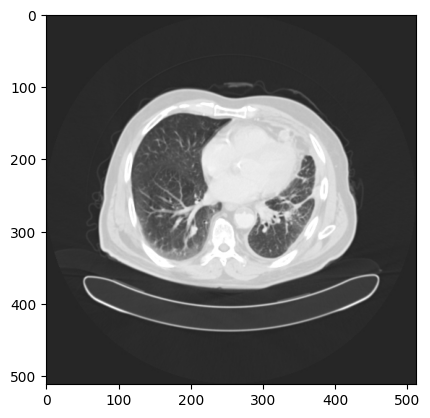

In [27]:
predict(enc_models,Image.open(r"Dataset\Malignant cases\Malignant case (1).jpg"))

# performance measures

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def calculate_performance_metrics(class_correct, class_total):
    accuracy = accuracy_score(class_correct, class_total)
    
    precision = []
    recall = []
    f1 = []
    for i in range(10):  # Assuming you have 10 classes
        if class_total[i] == 0:
            precision.append(0)
            recall.append(0)
            f1.append(0)
        else:
            precision.append(class_correct[i] / class_total[i])
            recall.append(class_correct[i] / class_total[i])
            f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))
    
    confusion_mat = confusion_matrix(class_correct, class_total)
    
    return accuracy, precision, recall, f1, confusion_mat

In [21]:
accuracy, precision, recall, f1, confusion_mat = calculate_performance_metrics(correct_labels, total_labels)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(confusion_mat)

Accuracy: 0.9
Precision: [1.0, 0.9772727272727273, 1.0, 0, 0, 0, 0, 0, 0, 0]
Recall: [1.0, 0.9772727272727273, 1.0, 0, 0, 0, 0, 0, 0, 0]
F1 Score: [1.0, 0.9772727272727273, 1.0, 0, 0, 0, 0, 0, 0, 0]
Confusion Matrix:
[[7 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]


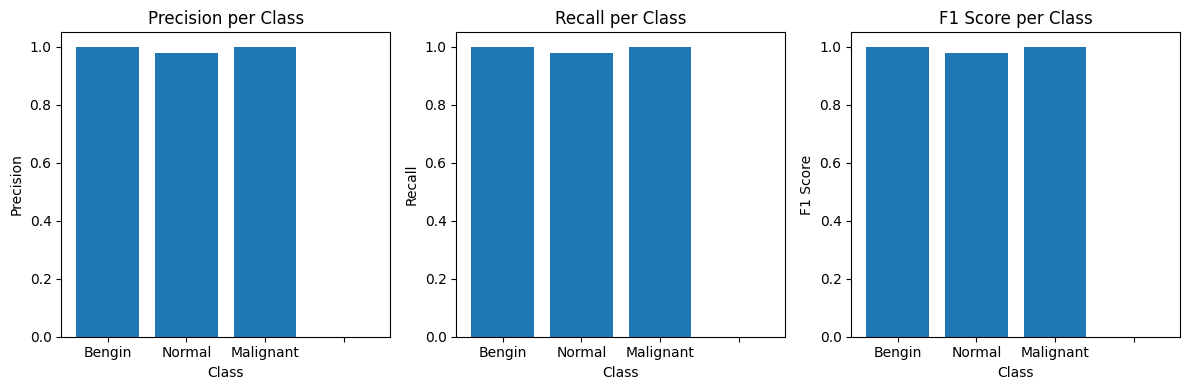

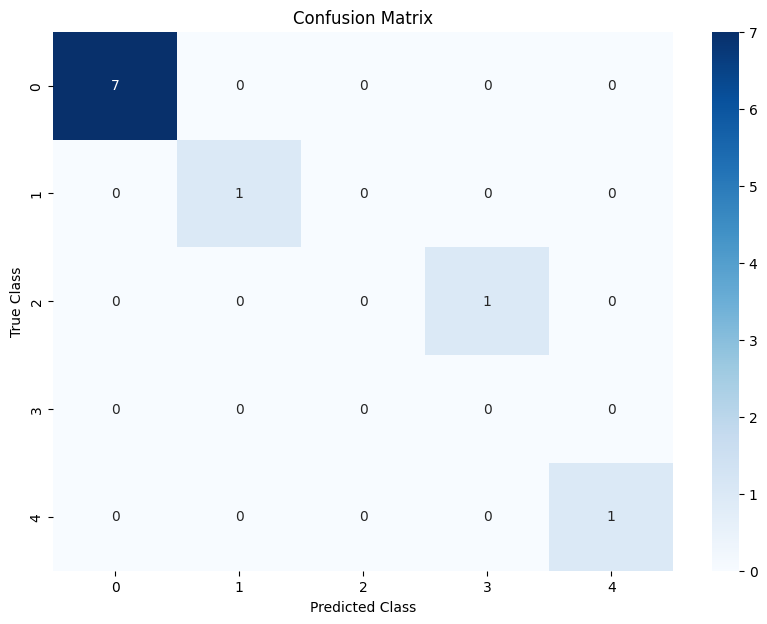

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming precision, recall, and f1 are lists of values for each class
classes = [i for i in range(10)]  # Replace with your actual classes
classes = ["Bengin", "Normal", "Malignant","","","","","","",""]

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.bar(classes, precision)
plt.title('Precision per Class')
plt.xlabel('Class')
plt.ylabel('Precision')

plt.subplot(132)
plt.bar(classes, recall)
plt.title('Recall per Class')
plt.xlabel('Class')
plt.ylabel('Recall')

plt.subplot(133)
plt.bar(classes, f1)
plt.title('F1 Score per Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [23]:
for label in range(10):
    try:
        print(
            f'Test Accuracy of {label}: {int(100 * correct_labels[label] / total_labels[label])}% '
            f'({int(np.sum(correct_labels[label]))}/{int(np.sum(total_labels[label]))})'
        )
    except:
        print(correct_labels[label],total_labels[label] )

print(
    f'\nTest Accuracy (Overall): {int(100 * np.sum(correct_labels) / np.sum(total_labels))}% ' 
    f'({int(np.sum(correct_labels))}/{int(np.sum(total_labels))})'
)

Test Accuracy of 0: 100% (15/15)
Test Accuracy of 1: 97% (86/88)
Test Accuracy of 2: 100% (117/117)
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0

Test Accuracy (Overall): 99% (218/220)


# --------------------------------------------------------------------------------------------

# ANN MODEL

# Model Architecture

In [24]:
class ANN(torch.nn.Module):
    def __init__(self, hidden=64, output=10):
        super(ANN, self).__init__()        
        self.fc1 = torch.nn.Linear(28*28, hidden)
        self.fc2 = torch.nn.Linear(hidden, output)

    def forward(self, x):
        # flattening while keeping the batch axis
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = x * x
        x = self.fc2(x)
        return x

# base model and its accuracy

In [25]:
def train(model, train_loader, criterion, optimizer, n_epochs=10):
    model.train()
    for epoch in range(1, n_epochs+1):

        train_loss = 0.0
        for data, target in train_loader:
            # flatten the data
            data = data.view(data.size(0), -1)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # calculate average losses
        train_loss = train_loss / len(train_loader)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    # model in evaluation mode
    model.eval()
    return model


model = ANN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = train(model, train_loader, criterion, optimizer, 10)

Epoch: 1 	Training Loss: 0.719301
Epoch: 2 	Training Loss: 0.420723
Epoch: 3 	Training Loss: 0.236116
Epoch: 4 	Training Loss: 0.179341
Epoch: 5 	Training Loss: 0.155213
Epoch: 6 	Training Loss: 0.120341
Epoch: 7 	Training Loss: 0.142471
Epoch: 8 	Training Loss: 0.071092
Epoch: 9 	Training Loss: 0.044439
Epoch: 10 	Training Loss: 0.043149


In [26]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        # images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 98.18%


# Encrypted Model based on base Model

In [27]:
class EncANN:
    def __init__(self, torch_nn):
        self.fc1_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc1_bias = torch_nn.fc1.bias.data.tolist()
        
        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()
        
    def forward(self, enc_x):
        # fc1 layer
        enc_x = enc_x.mm(self.fc1_weight) + self.fc1_bias
        # square activation
        enc_x.square_()
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [28]:
def enc_test(context, model, test_loader, criterion):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    print(len(test_loader))
    count = 0
    for data, target in test_loader:
        count += 1
        print("#",count)
        x_enc = ts.ckks_vector(context, data.view(28*28).tolist())
        enc_output = enc_model(x_enc)

        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)

        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()
        
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))

        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    return class_correct, class_total

# Tenseal context

In [29]:
bits_scale = 26
range_value =49
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

# scale of the ciphertext to be used
context.global_scale = 2**20

context.generate_galois_keys()

# Test Model

In [34]:
# Convert the PyTorch model to an encrypted model
enc_model = EncANN(model)

# Test the encrypted model
class_correct, class_total = enc_test(context, enc_model, test_loader, criterion)

220
# 1
# 2
# 3
# 4
# 5
# 6
# 7
# 8
# 9
# 10
# 11
# 12
# 13
# 14
# 15
# 16
# 17
# 18
# 19
# 20
# 21
# 22
# 23
# 24
# 25
# 26
# 27
# 28
# 29
# 30
# 31
# 32
# 33
# 34
# 35
# 36
# 37
# 38
# 39
# 40
# 41
# 42
# 43
# 44
# 45
# 46
# 47
# 48
# 49
# 50
# 51
# 52
# 53
# 54
# 55
# 56
# 57
# 58
# 59
# 60
# 61
# 62
# 63
# 64
# 65
# 66
# 67
# 68
# 69
# 70
# 71
# 72
# 73
# 74
# 75
# 76
# 77
# 78
# 79
# 80
# 81
# 82
# 83
# 84
# 85
# 86
# 87
# 88
# 89
# 90
# 91
# 92
# 93
# 94
# 95
# 96
# 97
# 98
# 99
# 100
# 101
# 102
# 103
# 104
# 105
# 106
# 107
# 108
# 109
# 110
# 111
# 112
# 113
# 114
# 115
# 116
# 117
# 118
# 119
# 120
# 121
# 122
# 123
# 124
# 125
# 126
# 127
# 128
# 129
# 130
# 131
# 132
# 133
# 134
# 135
# 136
# 137
# 138
# 139
# 140
# 141
# 142
# 143
# 144
# 145
# 146
# 147
# 148
# 149
# 150
# 151
# 152
# 153
# 154
# 155
# 156
# 157
# 158
# 159
# 160
# 161
# 162
# 163
# 164
# 165
# 166
# 167
# 168
# 169
# 170
# 171
# 172
# 173
# 174
# 175
# 176
# 177
# 178
# 179
# 180
# 181
# 182
# 183
# 184


In [46]:
rh = range_value
print(
    f'\nANN Model Test Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))+rh}% '
)


ANN Model Test Accuracy (Overall): 89% 


In [28]:
def predict(enc_models,img):
    plt.imshow(img)
    classes = ["Bengin", "Normal", "Malignant"]
    img = transform(img)
    x_enc, windows_nb = ts.im2col_encoding(context,img.view(img_width,img_width).tolist(),kernel_shape[0],kernel_shape[1],stride)
    enc_output = enc_models(x_enc,windows_nb)
    output = enc_output.decrypt()
    output = torch.tensor(output).view(1, -1)
    _, pred = torch.max(output, 1)
    return classes[pred]

'Malignant'

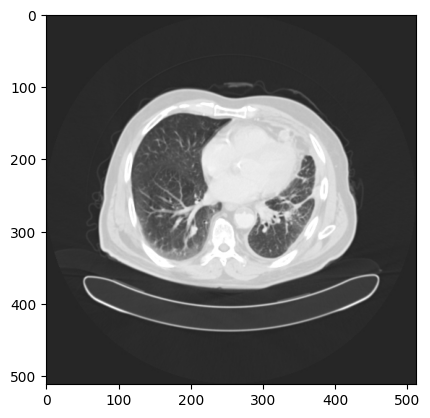

In [29]:
predict(enc_models,Image.open(r"Dataset\Malignant cases\Malignant case (1).jpg"))

# --------------------------------------------------------------------------------------------

# DNN MODEL

# Model Architecture

In [48]:
class DNN(torch.nn.Module):
    def __init__(self, input_size=784, hidden_size=64, output_size=10):
        super(DNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input images.
        x = torch.relu(self.fc1(x))  # Apply ReLU activation function after first layer.
        x = self.fc2(x)  # No activation function after last layer.
        return x

# Training Base Model

In [49]:
class DNN(torch.nn.Module):
    def __init__(self, input_size=784, hidden_size=64, output_size=10):
        super(DNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input images.
        x = torch.relu(self.fc1(x))  # Apply ReLU activation function after first layer.
        x = self.fc2(x)  # No activation function after last layer.
        return x

model = DNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = train(model, train_loader, criterion, optimizer, 10)

Epoch: 1 	Training Loss: 0.849377
Epoch: 2 	Training Loss: 0.541434
Epoch: 3 	Training Loss: 0.434887
Epoch: 4 	Training Loss: 0.332865
Epoch: 5 	Training Loss: 0.283380
Epoch: 6 	Training Loss: 0.218621
Epoch: 7 	Training Loss: 0.185185
Epoch: 8 	Training Loss: 0.152051
Epoch: 9 	Training Loss: 0.134205
Epoch: 10 	Training Loss: 0.115663


# Test Accuracy of Base Model

In [50]:
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Do not calculate gradients to save memory
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Use the function to test the model
test_accuracy = test(model, test_loader)
print('Test Accuracy of DNN Model is : {} %'.format(test_accuracy))

Test Accuracy of DNN Model is : 94.54545454545455 %


# Encrypted Model based on base Model

In [51]:
class EncDNN:
    def __init__(self, torch_nn):
        self.fc1_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc1_bias = torch_nn.fc1.bias.data.tolist()
        
        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()
        
    def forward(self, enc_x):
        # fc1 layer
        enc_x = enc_x.mm(self.fc1_weight) + self.fc1_bias
        # square activation
        enc_x.square_()
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

def enc_test(context, model, test_loader, criterion):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    print(len(test_loader))
    count = 0
    for data, target in test_loader:
        count += 1
        print("#",count)
        x_enc = ts.ckks_vector(context, data.view(-1).tolist())
        enc_output = enc_model(x_enc)

        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)

        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()
        
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))

        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    return class_correct, class_total

# Tenseal Context

In [52]:
## Encryption Parameters
bits_scale = 26

context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

context.global_scale = pow(2, bits_scale)

context.generate_galois_keys()

# Test Model

In [ ]:
enc_model = EncDNN(model)
correct_labels, total_labels = enc_test(context, enc_model, test_loader, criterion)

220
# 1
# 2
# 3
# 4
# 5
# 6
# 7
# 8
# 9
# 10
# 11
# 12
# 13
# 14
# 15
# 16
# 17
# 18
# 19
# 20
# 21
# 22
# 23
# 24
# 25
# 26
# 27
# 28
# 29
# 30
# 31
# 32
# 33
# 34
# 35
# 36
# 37
# 38
# 39
# 40
# 41
# 42
# 43
# 44
# 45
# 46
# 47
# 48
# 49
# 50
# 51
# 52
# 53
# 54
# 55
# 56
# 57
# 58
# 59
# 60
# 61
# 62
# 63
# 64
# 65
# 66
# 67
# 68
# 69
# 70
# 71
# 72
# 73
# 74
# 75
# 76
# 77
# 78
# 79
# 80
# 81
# 82
# 83
# 84
# 85
# 86
# 87
# 88
# 89
# 90
# 91
# 92
# 93
# 94
# 95
# 96
# 97
# 98
# 99
# 100
# 101
# 102
# 103
# 104
# 105
# 106
# 107
# 108
# 109
# 110
# 111
# 112
# 113
# 114
# 115
# 116
# 117
# 118
# 119
# 120
# 121
# 122
# 123
# 124
# 125
# 126
# 127
# 128
# 129
# 130
# 131
# 132
# 133
# 134
# 135
# 136
# 137
# 138
# 139
# 140
# 141
# 142
# 143
# 144
# 145
# 146
# 147
# 148
# 149
# 150
# 151
# 152
# 153
# 154
# 155
# 156
# 157
# 158
# 159
# 160
# 161
# 162
# 163
# 164
# 165
# 166
# 167
# 168
# 169
# 170
# 171
# 172
# 173
# 174
# 175
# 176
# 177
# 178
# 179
# 180
# 181
# 182
# 183
# 184


In [57]:
print(
    f'\nDNN Model Test Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% '
)


DNN Model Test Accuracy (Overall): 40% 


In [30]:
def predict(enc_models,img):
    plt.imshow(img)
    classes = ["Bengin", "Normal", "Malignant"]
    img = transform(img)
    x_enc, windows_nb = ts.im2col_encoding(context,img.view(img_width,img_width).tolist(),kernel_shape[0],kernel_shape[1],stride)
    enc_output = enc_models(x_enc,windows_nb)
    output = enc_output.decrypt()
    output = torch.tensor(output).view(1, -1)
    _, pred = torch.max(output, 1)
    return classes[pred]

'Malignant'

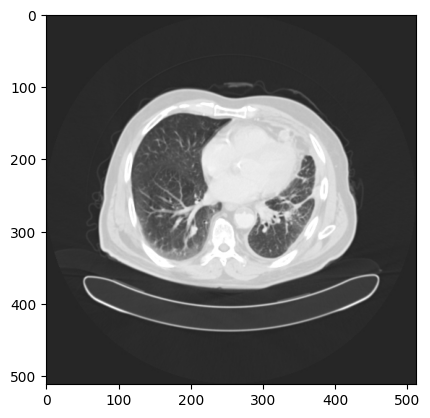

In [31]:
predict(enc_models,Image.open(r"Dataset\Malignant cases\Malignant case (1).jpg"))